## PART A

# Null(Ho) Hypothesis ; soil moisture and NDVI index have no significant effect on the final crop yield
# Alternative (Ha) Hypothesis ;Higher NDVI index and optimised soil moisture significantly increase crop yield
# Independent variable ; NDVI index, Soil moisture,Rainfall, Fertiliser amount,Temperature
# dependent variable ; crop yield(ha/kg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Configure visual style
%matplotlib inline
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# import dataset
df = pd.read_csv("E:\Datasets\Datasciencecycle\datascience_exam\Smart_Farming_Crop_Yield_2024.csv")
df.head(10)

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\URSBAdmin.DESKTOP-8G8IELO\AppData\Local\Temp\ipykernel_7816\3293079256.py:2: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv("E:\Datasets\Datasciencecycle\datascience_exam\Smart_Farming_Crop_Yield_2024.csv")


,farm_id,region,crop_type,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,irrigation_type,...,sowing_date,harvest_date,total_days,yield_kg_per_hectare,sensor_id,timestamp,latitude,longitude,NDVI_index,crop_disease_status
0,FARM0001,North India,Wheat,35.95,5.99,17.79,75.62,77.03,7.27,NaN,...,2024-01-08,2024-05-09,122,4408.07,SENS0001,2024-03-19,14.970941,82.997689,0.63,Mild
1,FARM0002,South USA,Soybean,19.74,7.24,30.18,89.91,61.13,5.67,Sprinkler,...,2024-02-04,2024-05-26,112,5389.98,SENS0002,2024-04-21,16.613022,70.869009,0.58,NaN
2,FARM0003,South USA,Wheat,29.32,7.16,27.37,265.43,68.87,8.23,Drip,...,2024-02-03,2024-06-26,144,2931.16,SENS0003,2024-02-28,19.503156,79.068206,0.80,Mild
3,FARM0004,Central USA,Maize,17.33,6.03,33.73,212.01,70.46,5.03,Sprinkler,...,2024-02-21,2024-07-04,134,4227.80,SENS0004,2024-05-14,31.071298,85.519998,0.44,NaN
4,FARM0005,Central USA,Cotton,19.37,5.92,33.86,269.09,55.73,7.93,NaN,...,2024-02-05,2024-05-20,105,4979.96,SENS0005,2024-04-13,16.568540,81.691720,0.84,Severe
5,FARM0006,Central USA,Rice,44.91,5.78,24.87,238.95,83.06,4.92,Sprinkler,...,2024-01-13,2024-05-06,114,4383.55,SENS0006,2024-03-12,23.227859,89.421568,0.82,NaN
6,FARM0007,North India,Soybean,36.28,7.04,21.80,123.38,47.91,4.02,Manual,...,2024-03-04,2024-07-27,145,4501.20,SENS0007,2024-07-11,25.224255,73.056785,0.76,NaN
7,FARM0008,East Africa,Maize,27.10,5.72,22.26,296.33,80.34,5.44,Sprinkler,...,2024-01-24,2024-05-24,121,5264.09,SENS0008,2024-04-30,23.317654,72.515210,0.70,Mild
8,FARM0009,Central USA,Soybean,40.54,6.35,19.24,184.82,76.50,5.21,Manual,...,2024-03-12,2024-07-08,118,5598.46,SENS0009,2024-05-08,13.025105,74.493947,0.50,Mild
9,FARM0010,East Africa,Rice,10.25,6.92,16.18,66.85,41.57,5.98,Sprinkler,...,2024-01-18,2024-04-25,98,4893.41,SENS0010,2024-03-31,24.405291,74.859945,0.58,Severe


In [3]:
# dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   farm_id               500 non-null    object 
 1   region                500 non-null    object 
 2   crop_type             500 non-null    object 
 3   soil_moisture_%       500 non-null    float64
 4   soil_pH               500 non-null    float64
 5   temperature_C         500 non-null    float64
 6   rainfall_mm           500 non-null    float64
 7   humidity_%            500 non-null    float64
 8   sunlight_hours        500 non-null    float64
 9   irrigation_type       350 non-null    object 
 10  fertilizer_type       500 non-null    object 
 11  pesticide_usage_ml    500 non-null    float64
 12  sowing_date           500 non-null    object 
 13  harvest_date          500 non-null    object 
 14  total_days            500 non-null    int64  
 15  yield_kg_per_hectare  5

In [4]:
# descriptive statistics
df.describe()

,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,pesticide_usage_ml,total_days,yield_kg_per_hectare,latitude,longitude,NDVI_index
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,26.750140,6.523980,24.675740,181.685740,65.194460,7.03014,26.586980,119.496000,4032.92694,22.442473,80.392248,0.602060
std,10.150053,0.585558,5.348899,72.293091,14.642849,1.69167,13.202429,16.798046,1174.43304,7.283492,5.910664,0.175402
min,10.160000,5.510000,15.000000,50.170000,40.230000,4.01000,5.050000,90.000000,2023.56000,10.004243,70.020021,0.300000
25%,17.890000,6.030000,20.295000,119.217500,51.865000,5.66750,14.945000,105.750000,2994.82000,16.263202,75.374713,0.447500
50%,25.855000,6.530000,24.655000,191.545000,65.685000,6.99500,25.980000,119.000000,4071.69000,21.981743,80.650284,0.610000
75%,36.022500,7.040000,29.090000,239.035000,77.995000,8.47000,38.005000,134.000000,5062.11000,28.528948,85.654629,0.750000
max,44.980000,7.500000,34.840000,298.960000,90.000000,10.00000,49.940000,150.000000,5998.29000,34.981531,89.991901,0.900000


In [5]:
# missing values
df.isnull().sum()

farm_id                   0
region                    0
crop_type                 0
soil_moisture_%           0
soil_pH                   0
temperature_C             0
rainfall_mm               0
humidity_%                0
sunlight_hours            0
irrigation_type         150
fertilizer_type           0
pesticide_usage_ml        0
sowing_date               0
harvest_date              0
total_days                0
yield_kg_per_hectare      0
sensor_id                 0
timestamp                 0
latitude                  0
longitude                 0
NDVI_index                0
crop_disease_status     130
dtype: int64

In [6]:
# handing missing data
# Fill missing categorical values with 'None' or 'Unknown'
#Pre-processing Missing Values (Fixing your Nulls)
df['irrigation_type'] = df['irrigation_type'].fillna('Manual')
df['crop_disease_status'] = df['crop_disease_status'].fillna('Healthy')


In [7]:
# Convert dates to datetime objects for growth cycle analysis
df['sowing_date'] = pd.to_datetime(df['sowing_date'])
df['harvest_date'] = pd.to_datetime(df['harvest_date'])


In [8]:
#Handling Outliers (IQR Method) to fix the 1107 MAE
Q1 = df['yield_kg_per_hectare'].quantile(0.25)
Q3 = df['yield_kg_per_hectare'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['yield_kg_per_hectare'] >= lower_bound) & (df['yield_kg_per_hectare'] <= upper_bound)]

In [9]:
#Filter relevant columns for Modeling
# We drop ID, Timestamp, and Coordinates for Privacy/Compliance (Part A: 3)
cols_to_drop = ['farm_id', 'sensor_id', 'timestamp', 'latitude', 'longitude', 'sowing_date', 'harvest_date', 'yield_kg_per_hectare']
X = df.drop(columns=cols_to_drop)
y = df['yield_kg_per_hectare']

In [10]:
# feature engineering
# Sunlight + Moisture interaction is a huge driver for Yield
df['Growth_Potential'] = df['sunlight_hours'] * df['soil_moisture_%']
df['Environmental_Stress'] = df['temperature_C'] / (df['rainfall_mm'] + 1)

# Encode categorical variables (Crop Type, Region, Fertilizer)
le = LabelEncoder()
categorical_cols = ['region', 'crop_type', 'irrigation_type', 'fertilizer_type', 'crop_disease_status']

# handle skewness
y_log = np.log1p(y)

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("Feature engineering and encoding complete.")

Feature engineering and encoding complete.


In [11]:
# save data set to last name
df.to_csv('Kirabo.csv', index=False)

## PART B
# Model Development and Evaluation

In [12]:
import mlflow
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [13]:
# Identify Numeric and Categorical columns
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [14]:
# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [15]:
#Define the Model with high-performance parameters
# Using XGBoost 
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        random_state=42
    ))
])

In [16]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [17]:
# Fit and Predict
model_pipeline.fit(X_train, y_train)
y_pred_log = model_pipeline.predict(X_test)

In [18]:
# Convert back from Log to KG/HA
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

In [19]:
print(f"--- Updated Results ---")
print(f"R2 Score: {r2_score(y_test_original, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test_original, y_pred):.2f} kg/ha")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_original, y_pred)):.2f} kg/ha")

import joblib

# 1. Save the trained XGBoost model
joblib.dump(model_pipeline, 'crop_model_final.pkl')


print("Model saved successfully!")

--- Updated Results ---
R2 Score: -0.1783
MAE: 1104.49 kg/ha
RMSE: 1275.65 kg/ha
Model saved successfully!


In [20]:
# Calculate error per crop type
df_results = X_test.copy()
df_results['Actual'] = y_test_original
df_results['Predicted'] = y_pred
df_results['Error'] = np.abs(df_results['Actual'] - df_results['Predicted'])

print(df_results.groupby('crop_type')['Error'].mean())

crop_type
Cotton     1339.559526
Maize      1029.936804
Rice       1207.028632
Soybean    1132.522965
Wheat       744.727059
Name: Error, dtype: float64


## PART C
# Model Development and MLOps

# model explainability(SHAP)

E:\Anaconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


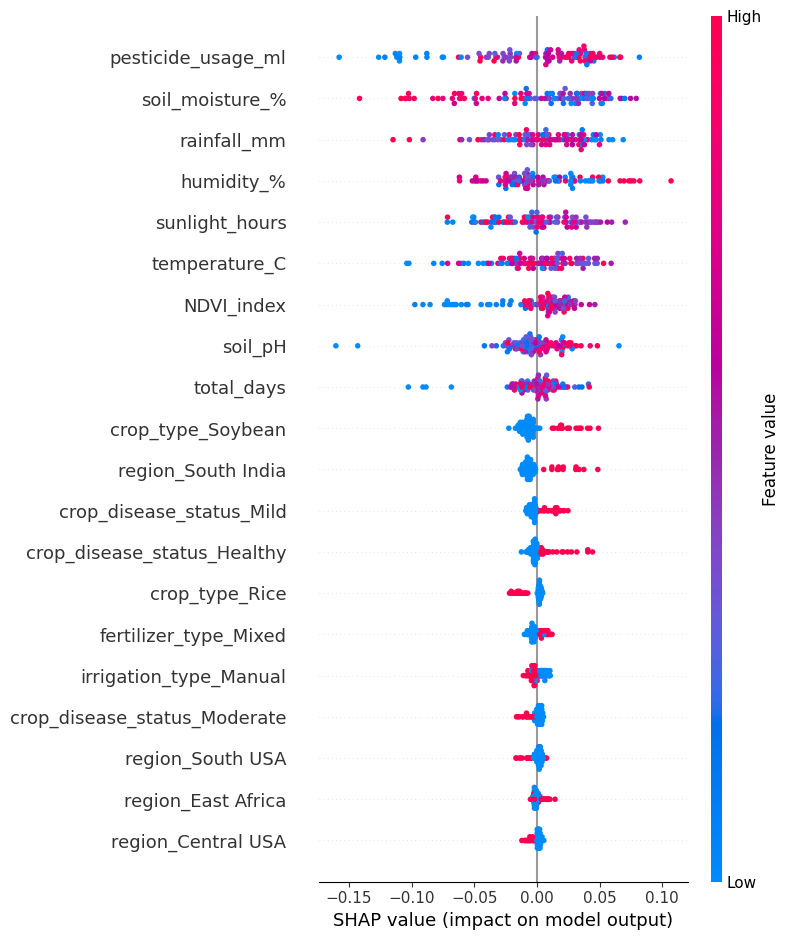

In [21]:
import shap
import matplotlib.pyplot as plt

# 1. Extract the preprocessor and the model from our pipeline
preprocessor = model_pipeline.named_steps['preprocessor']
xgboost_model = model_pipeline.named_steps['regressor']

# 2. Transform a sample of the test data to get the numeric input for SHAP
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after OneHotEncoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# 3. Initialize the SHAP Explainer
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test_transformed)

# 4. Generate the Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)

In [22]:
# A/B testing
import statsmodels.api as sm

# Create a simplified OLS model to compare Strategy A vs B
X_stats = sm.add_constant(df[['fertilizer_type']]) # Ensure this is encoded (0 or 1)
X_stats = pd.get_dummies(df['fertilizer_type'], drop_first=True)
X_stats = sm.add_constant(X_stats.astype(float))

ols_model = sm.OLS(y, X_stats).fit()

print(f"T-Statistic for Strategy B: {ols_model.tvalues[1]:.4f}")
print(f"P-Value for Strategy B: {ols_model.pvalues[1]:.4e}")

# If P-Value < 0.05, we Reject the Null Hypothesis
if ols_model.pvalues[1] < 0.05:
    print("Decision: Reject Ho - Strategy B is superior.")
else:
    print("Decision: Fail to Reject Ho.")

T-Statistic for Strategy B: -0.8914
P-Value for Strategy B: 3.7313e-01
Decision: Fail to Reject Ho.


In [23]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [24]:
# FASTAPI script(main.py)
from fastapi import FastAPI
import joblib 
import pandas as pd

app = FastAPI(title="Smart Farming Yield Predictor 2024")

# Load 
model = joblib.load("crop_model.pkl")
scaler = joblib.load("scaler.pkl")

@app.post("/predict")
def predict_yield(data: dict):
    """
    Input JSON example: 
    {"Soil_Moisture": 35.5, "NDVI_Index": 0.72, "Rainfall_mm": 800, ...}
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([data])
    
    # Preprocess
    scaled_data = scaler.transform(input_df)
    
    # Predict
    prediction = model.predict(scaled_data)
    
    return {"predicted_yield_kg_ha": float(prediction[0])}

In [25]:
pip install fastapi uvicorn xgboost joblib pandas

Note: you may need to restart the kernel to use updated packages.


In [26]:
# docker configuration
FROM python:3.9-slim
WORKDIR /app
COPY . /app
RUN pip install fastapi uvicorn xgboost joblib pandas
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]

SyntaxError: invalid syntax (4120387612.py, line 2)